In [1]:
import pandas as pd
import numpy as np
import bz2
import json
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from IPython import display
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.5.0')
%matplotlib inline

In [2]:
stints = []
with bz2.open('data/matchups-2016-2018.json.bz2', 'r') as f:
    for line in f:
        stints.append(json.loads(line))
print(stints[0][stints[0]['home']])
print(stints[0][stints[0]['away']])

{'on': ['George Hill', 'Monta Ellis', 'Paul George', 'Jordan Hill', 'Ian Mahinmi'], 'entered': [], 'exited': [], 'stats': {'poss': 6, 'time': 0, 'pts': 5, 'oreb': 1, 'dreb': 2, 'orebx': 3, 'drebx': 2, 'tov': 0, 'team_tov': 0, 'non_steal_tov': 0, 'fta': 1, 'ftm': 1, 'foul': 2, 'fgm': 2, 'fgx': 5, 'fg2m': 2, 'fg3m': 0}}
{'on': ['Mike Conley', 'Courtney Lee', 'Tony Allen', 'Zach Randolph', 'Marc Gasol'], 'entered': [], 'exited': [], 'stats': {'poss': 5, 'time': 0, 'pts': 9, 'oreb': 2, 'dreb': 3, 'orebx': 2, 'drebx': 1, 'tov': 0, 'team_tov': 0, 'non_steal_tov': 0, 'fta': 1, 'ftm': 1, 'foul': 3, 'fgm': 4, 'fgx': 4, 'fg2m': 4, 'fg3m': 0}}


In [86]:
matchups = []
ratings = []
weights = []

for stint in stints:
    home = stint['home']
    away = stint['away']
    poss = (stint[home]['stats']['poss'] + stint[away]['stats']['poss'])/2

    home_unit = {"{}".format(name): 1 for name in stint[home]['on']}
    away_unit = {"{}".format(name): -1 for name in stint[away]['on']}

    matchup = home_unit.copy()
    matchup.update(away_unit)

    if poss >= 1:  # to avoid some ill-conditioning we only use stints that have possessions >= 1
        delta = 100*(stint[home]['stats']['pts']-stint[away]['stats']['pts'])/poss
        matchups.append(matchup)
        ratings.append(delta)
        weights.append(poss)

dv = DictVectorizer(sparse=False)
features = dv.fit_transform(matchups)
players = dv.get_feature_names()
train_features, test_features, train_ratings, test_ratings, train_weights, test_weights = train_test_split(features, ratings, weights, test_size=0.15)
print(matchups[0],ratings[0],weights[0])

{'George Hill': 1, 'Monta Ellis': 1, 'Paul George': 1, 'Jordan Hill': 1, 'Ian Mahinmi': 1, 'Mike Conley': -1, 'Courtney Lee': -1, 'Tony Allen': -1, 'Zach Randolph': -1, 'Marc Gasol': -1} -72.72727272727273 5.5


In [88]:
len(test_features)

15735

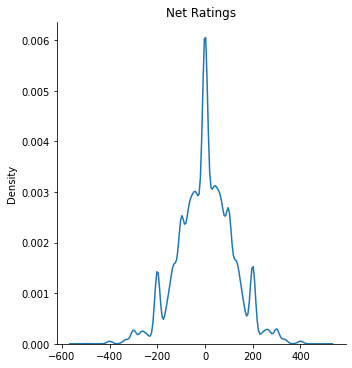

In [4]:
fig = sns.displot(data=np.array(ratings),kind='kde')
fig.set(title='Net Ratings')

In [71]:
# Normal distribution

# loss = 160

# def model(features, ratings):
#     hca = pyro.sample("HCA", dist.Uniform(0,10))
#     beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
#     sigma = pyro.sample("sigma", dist.Uniform(0,200))
#     for i in pyro.plate("data", len(features), subsample_size=1000):
#         x = torch.Tensor(features[i])
#         mu = hca + torch.dot(x, beta)
#         pyro.sample(f"result_{i}", dist.Normal(mu, sigma), obs=ratings[i])

In [89]:
# loss = 222
# def model(features, ratings, weights):
#     hca = pyro.sample("HCA", dist.Uniform(0,10))
#     beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
#     sigma = pyro.sample("sigma", dist.Uniform(0,200))
#     for i in pyro.plate("data", len(features), subsample_size=1000):
#         w = weights[i]
#         x = torch.Tensor(features[i])
#         mu = hca + torch.dot(x, beta)
#         pyro.sample(f"result_{i}", dist.Normal(mu, sigma/w), obs=ratings[i])

In [97]:
# loss = 143
# def model(features, ratings):
#     hca = pyro.sample("HCA", dist.Uniform(0,10))
#     beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
#     sigma = pyro.sample("sigma", dist.Uniform(0,200))
#     for i in pyro.plate("data", len(features), subsample_size=1000):
#         x = torch.Tensor(features[i])
#         mu = hca + torch.dot(x, beta)
#         pyro.sample(f"result_{i}", dist.Laplace(mu, sigma), obs=ratings[i])

In [107]:
# loss = 138.6

# def model(features, ratings, weights):
#     hca = pyro.sample("HCA", dist.Uniform(0,10))
#     beta = pyro.sample("beta", dist.Normal(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
#     sigma = pyro.sample("sigma", dist.Uniform(0,200))
#     for i in pyro.plate("data", len(features), subsample_size=1000):
#         x = torch.Tensor(features[i])
#         mu = hca + torch.dot(x, beta)
#         pyro.sample(f"result_{i}", dist.StudentT(weights[i], mu, sigma), obs=ratings[i])

In [117]:
# loss = 137.6

def model(features, ratings, weights):
    hca = pyro.sample("HCA", dist.Uniform(0,10))
    beta = pyro.sample("beta", dist.Cauchy(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
    sigma = pyro.sample("sigma", dist.Uniform(0,200))
    for i in pyro.plate("data", len(features), subsample_size=1000):
        x = torch.Tensor(features[i])
        mu = hca + torch.dot(x, beta)
        pyro.sample(f"result_{i}", dist.StudentT(weights[i], mu, sigma), obs=ratings[i])

In [136]:
def model(features, ratings):
    hca = pyro.sample("HCA", dist.Uniform(0,10))
    beta = pyro.sample("beta", dist.Cauchy(torch.zeros(features.shape[-1]),torch.ones(features.shape[-1])))  
    sigma = pyro.sample("sigma", dist.Uniform(0,200))
    for i in pyro.plate("data", len(features), subsample_size=1000):
        x = torch.Tensor(features[i])
        mu = hca + torch.dot(x, beta)
        pyro.sample(f"result_{i}", dist.Normal(mu, sigma), obs=ratings[i])

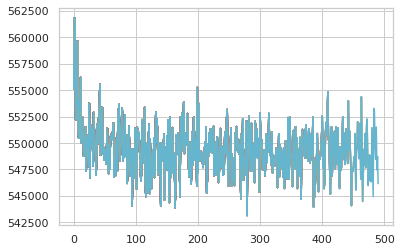

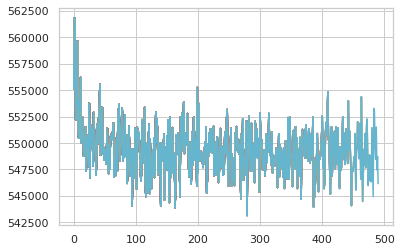

In [138]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model=model, guide=guide, optim=adam, loss=Trace_ELBO())

pyro.clear_param_store()
iters = 500
losses = []
for j in range(iters):
    # calculate the loss and take a gradient step
    loss = svi.step(train_features, train_ratings)
    losses.append(loss)
    if j % 10 == 0:
#         print("[iteration %04d] loss: %.4f" % (j, loss/1000))
        sns.set_theme(style='whitegrid')
        sns.lineplot(data=losses)
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [139]:
guide.requires_grad_(False)

beta_mu = pyro.param('AutoDiagonalNormal.loc')[1:]
beta_sigma = pyro.param('AutoDiagonalNormal.scale')[1:]

In [140]:
xpm = sorted(list(zip(beta_mu.numpy(),beta_sigma.numpy(),beta_mu.numpy()-2*beta_sigma.numpy(), beta_mu.numpy()+2*beta_sigma.numpy(),players)),key=lambda x: -x[0])
ranked_players = []
for idx, obj in enumerate(xpm):
    ranked_players.append(obj[4])
    if idx+1 <= 25:
        print(f"{idx+1}.{obj[4]} {obj[0]:0.3} ({obj[1]:.2})")

1.Stephen Curry 6.9 (1.5)
2.Kawhi Leonard 5.01 (2.2)
3.Draymond Green 4.75 (1.7)
4.Andre Iguodala 4.59 (5.5)
5.Chris Paul 4.57 (1.8)
6.Nikola Jokic 4.08 (1.7)
7.James Harden 3.86 (1.4)
8.Kyle Lowry 3.65 (1.7)
9.LeBron James 3.61 (1.5)
10.Rudy Gobert 3.31 (1.7)
11.Russell Westbrook 3.24 (1.4)
12.Kevin Durant 3.09 (1.6)
13.J.J. Redick 2.52 (2.7)
14.Eric Gordon 2.5 (1.2)
15.Kyrie Irving 2.44 (2.6)
16.Cody Zeller 2.38 (2.7)
17.Manu Ginobili 2.37 (1.5)
18.Klay Thompson 2.33 (1.1)
19.Steven Adams 2.27 (2.2)
20.Joel Embiid 2.22 (1.7)
21.Kevin Love 2.2 (1.4)
22.Serge Ibaka 2.16 (1.7)
23.Nene 2.08 (3.7)
24.Kyle Korver 2.04 (1.1)
25.Victor Oladipo 1.94 (1.5)


In [141]:
samples = []
for i in range(82):
    sample = list(zip(players,guide.sample_latent()[1:].numpy()))
    for player, value in sample:
        samples.append((player, value))

<AxesSubplot:xlabel='value', ylabel='player'>

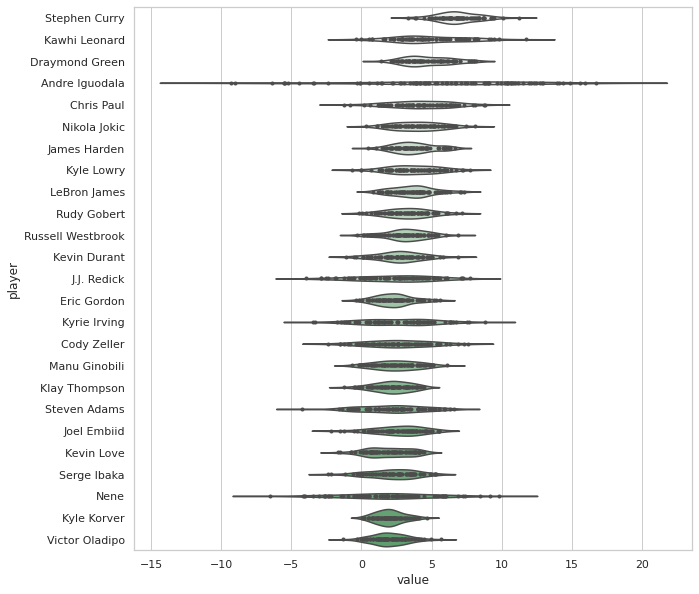

In [142]:
df = pd.DataFrame.from_records(samples,columns=['player','value'])
fig, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data=df.where(df.player.isin(ranked_players[:25])), x='value', y='player',palette="light:g", inner="points", orient="h",order=ranked_players[:25])

In [144]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=82, return_sites=("HCA","sigma","alpha"))
samples = predictive(test_features,torch.tensor(test_ratings))
print(samples)

{'HCA': tensor([3.1567, 2.9753, 3.2455, 3.5946, 2.9537, 3.2603, 2.7339, 3.2500, 3.0633,
        3.1545, 3.3824, 2.5640, 3.2222, 3.2582, 3.0699, 3.4200, 3.3629, 3.1729,
        3.3741, 3.1194, 3.1346, 3.1533, 3.1939, 3.3652, 3.1525, 3.3261, 2.5959,
        2.4624, 3.1573, 2.8263, 3.4198, 2.9772, 2.7915, 3.0021, 3.2395, 3.8684,
        3.3416, 2.8936, 3.4011, 2.9298, 3.2614, 2.9556, 3.0537, 2.7083, 2.8161,
        3.2610, 3.0535, 3.0264, 3.1716, 3.1405, 2.6508, 3.5800, 2.9912, 2.8990,
        2.4745, 3.0786, 3.5608, 3.3602, 2.5473, 2.8946, 3.2173, 2.7890, 3.3559,
        2.9184, 2.9441, 3.2415, 2.8217, 3.0457, 3.2112, 2.8023, 2.8547, 3.4695,
        3.5683, 3.4150, 3.2426, 3.0817, 3.1361, 3.0468, 3.1823, 2.3195, 3.0355,
        2.9130]), 'sigma': tensor([111.3119, 111.4650, 112.6122, 113.8937, 113.9110, 112.9424, 111.9815,
        113.1373, 113.6239, 112.7229, 113.9714, 111.8293, 111.1886, 113.5206,
        111.2227, 111.1017, 112.8809, 112.2817, 114.9488, 113.9934, 113.2216,
        112

In [ ]:
losses = []
for i in range(len(test_features)):
    sample = guide.forward()
    mu = np.dot(test_features[i],sample['beta'])+sample['HCA']
    norm = pyro.distributions.Normal(mu, sample['sigma'])
    losses.append(np.power(norm.sample()-test_ratings[i],2))
sns.displot(np.array(losses))

In [135]:
np.sqrt(np.mean(np.array(losses)))

137.91552644291954